# **Prétraitement**

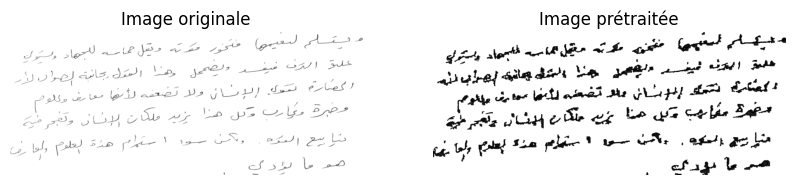

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image = cv2.imread("image_manuscrite.jpg", cv2.IMREAD_GRAYSCALE)

#filtrage médian pour réduire le bruit
image_filtre = cv2.medianBlur(image, 5)

# Normaliser l'image pour améliorer le contraste
image_norm = cv2.equalizeHist(image_filtre)

#affichage
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Image originale")
plt.imshow(image, cmap="gray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Image prétraitée")
plt.imshow(image_norm, cmap="gray")
plt.axis("off")
plt.show()

# **Implémentation de la croissance de régions**

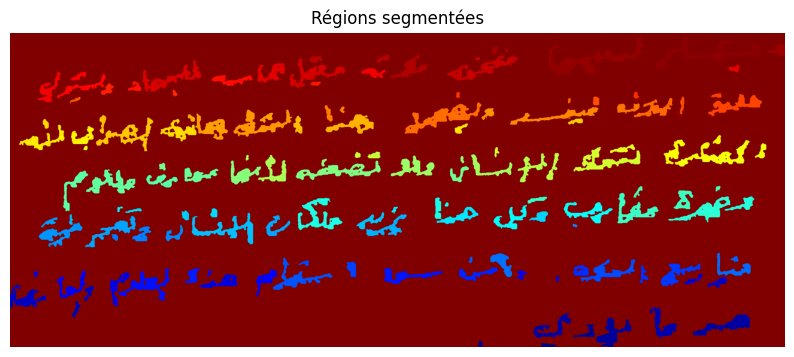

In [5]:
def croissance_regions(image, seuil=20, seuil_seed=20):

    h, w = image.shape
    visited = np.zeros((h, w), dtype=bool)
    regions = np.zeros((h, w), dtype=np.int32)
    region_id = 1

    for i in range(h):
        for j in range(w):
            # Condition pour qu'un pixel soit un seed
            if not visited[i, j] and image[i, j] <= seuil_seed:
                region_pixels = [(i, j)]
                intensite_seed = image[i, j]

                while region_pixels:
                    x, y = region_pixels.pop()

                    if not visited[x, y]:
                        visited[x, y] = True
                        regions[x, y] = region_id

                        # Vérifier les voisins
                        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                            nx, ny = x + dx, y + dy

                            if 0 <= nx < h and 0 <= ny < w:
                                if not visited[nx, ny]:
                                    # Vérifier la condition d'homogénéité
                                    if abs(int(image[nx, ny]) - int(intensite_seed)) <= seuil:
                                        region_pixels.append((nx, ny))

                region_id += 1

    return regions


#appliquer la croissance de régions
regions = croissance_regions(image_norm)

# générer une image colorée pour visualisation
region_colored = cv2.applyColorMap((regions * 255 // regions.max()).astype(np.uint8), cv2.COLORMAP_JET)

# afficher les régions
plt.figure(figsize=(10, 5))
plt.title("Régions segmentées")
plt.imshow(region_colored)
plt.axis("off")
plt.show()

# **Post-traitement**

In [6]:
# Supprimer les régions trop petites et extraire des sous-images
def post_traitement(regions, min_size=50):
    unique_regions, counts = np.unique(regions, return_counts=True)
    filtered_regions = np.zeros_like(regions)

    for region, count in zip(unique_regions, counts):
        if count >= min_size:
            filtered_regions[regions == region] = region

    return filtered_regions

# Supprimer les régions trop petites
filtered_regions = post_traitement(regions)

# Extraire les boîtes englobantes
boites_englobantes = []
for region_id in np.unique(filtered_regions):
    if region_id == 0:
        continue

    y, x = np.where(filtered_regions == region_id)
    x_min, x_max = x.min(), x.max()
    y_min, y_max = y.min(), y.max()
    boites_englobantes.append((x_min, y_min, x_max, y_max))

# **Résultats**

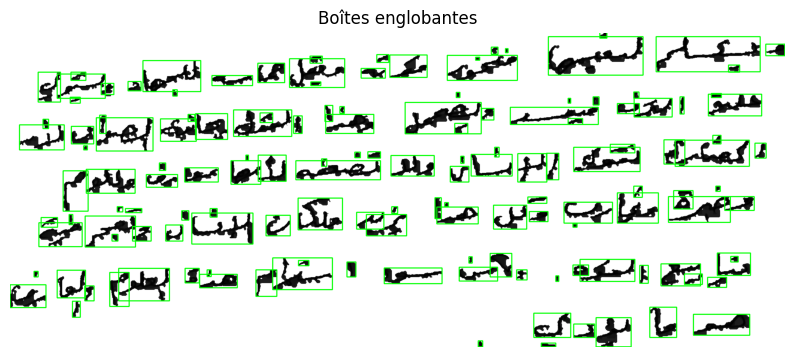

In [7]:
# Affichage des boîtes englobantes
output_image = cv2.cvtColor(image_norm, cv2.COLOR_GRAY2BGR)
for (x_min, y_min, x_max, y_max) in boites_englobantes:
    cv2.rectangle(output_image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

plt.figure(figsize=(10, 5))
plt.title("Boîtes englobantes")
plt.imshow(output_image)
plt.axis("off")
plt.show()